# SimulationAPI
This notebooks provides examples in how to use the lenstronomy.SimulationAPI modules in simulating (realistic) mock lenses taylored to a specific observation and instrument.

The module enables to use the astronomical magnitude conventions and can translate those into the lenstronomy core module configurations.

In [182]:
import copy
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import corner
%matplotlib inline
import time
# make sure lenstronomy is installed, otherwise install the latest pip version
try:
    import lenstronomy
except:
    !pip install lenstronomy

# lenstronomy module import
import lenstronomy.Util.data_util as data_util
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LightModel.Profiles.gaussian import GaussianEllipse
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util
# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
gauss = GaussianEllipse()


## simulation choices
We define the observational conditions and the instrument the mock data is produced with.

In [183]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

## Define camera and observations
As an example, we define the camera and observational settings of a LSST-like observation. We define one camera setting and three different observations corresponding th g,r,i imaging.

For the complete list of possible settings, we refer to the SimulationAPI.observation_api classes. There are pre-configured settings which approximately mimic observations from current and future instruments. Be careful using those and check whether they are sufficiently accurate for your specific science case!

In [184]:
# Instrument setting from pre-defined configurations

from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST

LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
kwargs_g_band = LSST_g.kwargs_single_band()
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
kwargs_r_band = LSST_r.kwargs_single_band()
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)
kwargs_i_band = LSST_i.kwargs_single_band()

# lenstronomy provides these setting to be imported with the SimulationAPI.observation_constructor routines.


In [185]:
#Tailored individual settings (as an example):


LSST_camera = {'read_noise': 10,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.263,  # scale (in arcseonds) of pixels
               'ccd_gain': 4.5  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

LSST_g_band_obs = {'exposure_time': 15.,  # exposure time per image (in seconds)
                   'sky_brightness': 22.26,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 28.30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 1,  # number of exposures that are combined
                   'seeing': 0.77,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

LSST_r_band_obs = {'exposure_time': 15.,
                   'sky_brightness': 21.2,
                   'magnitude_zero_point': 28.13,
                   'num_exposures': 1,
                   'seeing': 0.73,
                   'psf_type': 'GAUSSIAN'}

LSST_i_band_obs = {'exposure_time': 15.,
                   'sky_brightness': 20.48,
                   'magnitude_zero_point': 27.79,
                   'num_exposures': 1,
                   'seeing': 0.71,
                   'psf_type': 'GAUSSIAN'}

# here we merge observations and instrument for the three bands
kwargs_g_band = util.merge_dicts(LSST_camera, LSST_g_band_obs)
kwargs_r_band = util.merge_dicts(LSST_camera, LSST_r_band_obs)
kwargs_i_band = util.merge_dicts(LSST_camera, LSST_i_band_obs)

## Define model settings

The model settings are handled by the SimulationAPI.model_api ModelAPI class. 
The role is to return instances of the lenstronomy LightModel, LensModel, PointSource modules according to the options chosen by the user. Currently, all other model choices are equivalent to the ones provided by LightModel, LensModel, PointSource.
The current options of the class instance only describe a subset of possibilities and we refer to the specific class instances for details about all the possibilities.

For this example, we chose a single lens plane and a single source plane, elliptical Sersic profiles and an additional lensed point source.

In [186]:
# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 2.56, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model
kwargs_nfw = {'alpha_Rs': 0.02, 'r_core' : 0.24,'Rs': 0.68, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR', 'CNFW']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_x = 0.3
source_y = 0.1


# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list
            }

## Generate SimAPI instance for the different observations
Here we make an instanbce of the SimAPI class and execute the major tasks accessible as the interface to the ImSim core module.

In [187]:
numpix = 64  # number of pixels per axis of the image to be modelled

# here we define the numerical options used in the ImSim module. 
# Have a look at the ImageNumerics class for detailed descriptions.
# If not further specified, the default settings are used.
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)
sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model)

# return the ImSim instance. With this class instance, you can compute all the
# modelling accessible of the core modules. See class documentation and other notebooks.
imSim_g = sim_g.image_model_class(kwargs_numerics)
imSim_r = sim_r.image_model_class(kwargs_numerics)
imSim_i = sim_i.image_model_class(kwargs_numerics)

# kwargs_data_g = [sim_g.data_class.background_rms, sim_g.data_class.exp_time, sim_g.kwargs_data]
# print( sim_g.kwargs_data)

## Brightness definitions in magnitude space
One core feature is the support of light profile amplitudes in astronomical magnitude space (at least for few selected well defined brightness profiles).

We first define all parameters in magnitude space and then use the SimAPI routine to translate the arguments into lenstronomy conventions used by the ImSim module. The second model of each light component we defined as 'INTERPOL', which sets an interpolation grid given an image. This can be used to past real galaxies as lenses or sources into lenstronomy.

In [188]:

# g-band

# lens light
kwargs_lens_light_mag_g = [{'magnitude': 14, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 19, 'R_sersic': 0.3, 'n_sersic': 1, 'e1': -0.3, 'e2': -0.2, 'center_x': 0, 'center_y': 0}]
# point source
kwargs_ps_mag_g = [{'magnitude': 21, 'ra_source': 0.03, 'dec_source': 0}]



# and now we define the colors of the other two bands

# r-band
g_r_source = 1  # color mag_g - mag_r for source
g_r_lens = -1  # color mag_g - mag_r for lens light
g_r_ps = 0
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source

kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps


# i-band
g_i_source = 2
g_i_lens = -2
g_i_ps = 0
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'] -= g_i_source

kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps

# turn magnitude kwargs into lenstronomy kwargs
kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)


## setting lens model parameters
And finally we need a lens model. The default lensing units are in observed deflection angle (arc seconds) mapping the image to the source plane (reduced angles). In a single lens and single source plane model, this is all we need to specify and no futher cosmology is required.

In [189]:
# kwargs_lens = [
#     {'theta_E': 2., 'e1': 0.4, 'e2': -0.1, 'center_x': 0, 'center_y': 0},  # SIE model
#     {'gamma1': 0.03, 'gamma2': 0.01, 'ra_0': 0, 'dec_0': 0}  # SHEAR model
# ]


## simluate image
Finally we can simulate the images with the ImageModel class instance and the lenstronomy parameters for the different bands. Note that in the specific example we included a point source (representing a quasar) in the center of the lensed galaxy. The SimulationAPI supports various options. Further down below we simulate multi-lens multi-source plane configurations too.

0.263 15.0 pixel_size 0.263
dict_keys(['background_rms', 'exposure_time', 'ra_at_xy_0', 'dec_at_xy_0', 'transform_pix2angle', 'image_data'])
{'psf_type': 'GAUSSIAN', 'fwhm': 0.77, 'pixel_size': np.float64(0.263), 'kernel_point_source': array([[7.91494275e-12, 2.77763718e-10, 5.10449469e-09, 4.91223911e-08,
        2.47545903e-07, 6.53253116e-07, 9.02727638e-07, 6.53253116e-07,
        2.47545903e-07, 4.91223911e-08, 5.10449469e-09, 2.77763718e-10,
        7.91494275e-12],
       [2.77763718e-10, 9.74772468e-09, 1.79135019e-07, 1.72388082e-06,
        8.68727324e-06, 2.29249939e-05, 3.16799492e-05, 2.29249939e-05,
        8.68727324e-06, 1.72388082e-06, 1.79135019e-07, 9.74772468e-09,
        2.77763718e-10],
       [5.10449469e-09, 1.79135019e-07, 3.29198414e-06, 3.16799492e-05,
        1.59646985e-04, 4.21295159e-04, 5.82185946e-04, 4.21295159e-04,
        1.59646985e-04, 3.16799492e-05, 3.29198414e-06, 1.79135019e-07,
        5.10449469e-09],
       [4.91223911e-08, 1.72388082e-06, 3

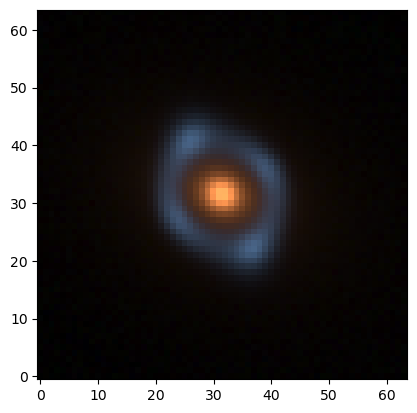

-2.604956125619064 13897.962950180687


/tmp/ipykernel_3790809/1106416289.py:55: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(image_g), origin='lower',  cmap=cmap, extent=[0, 1, 0, 1])


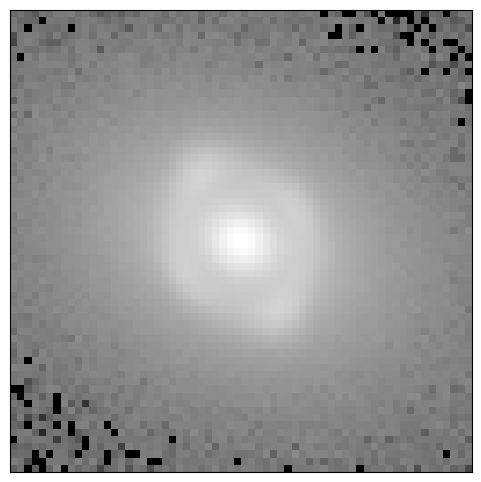

In [190]:
image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r)
image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i)

# add noise
image_g += sim_g.noise_for_model(model=image_g)
image_r += sim_r.noise_for_model(model=image_r)
image_i += sim_i.noise_for_model(model=image_i)

# image_g = image_g/200
# image_g = np.sqrt(abs(image_g))
print(kwargs_g_band['pixel_scale'], kwargs_g_band['exposure_time'],'pixel_size', imSim_g.Data.pixel_width )
# # initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
kwargs_data = sim_util.data_configure_simple(numpix,imSim_g.Data.pixel_width, kwargs_g_band['exposure_time'],imSim_g.Data.background_rms)
print(kwargs_data.keys())

data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_data['image_data'] = image_g
data_class.update_data(image_g)
kwargs_psf = {'psf_type': imSim_g.PSF.psf_type, 'fwhm': imSim_g.PSF.fwhm, 'pixel_size': imSim_g.Data.pixel_width, 'kernel_point_source': imSim_g.PSF.kernel_point_source}

print(kwargs_psf)

# and plot it

img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
img[:,:,0] = plot_util.sqrt(image_g, scale_min=0, scale_max=10000)
img[:,:,1] = plot_util.sqrt(image_r, scale_min=0, scale_max=10000)
img[:,:,2] = plot_util.sqrt(image_i, scale_min=0, scale_max=10000)

plt.clf()
plt.imshow(img, aspect='equal', origin='lower')
plt.show()

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# print(sim_g.data_class.data)
# print(sim_g.kwargs_data['image_data'])
# sim_g.kwargs_data['image_data'] = image_g
# sim_g.data_class.update_data(image_g)
# print(sim_g.data_class.data)
# print(sim_g.kwargs_data['image_data'])
v_min = 0
v_max = 2
print(min((image_g.flatten())), max((image_g.flatten())))
f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_g), origin='lower',  cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()


# Recovering the input parameters
Now we use lenstronomy to recover the input parameters. First, we want to have a fair estimate of the macro-model parameters and we do not add the NFW subclump.

We define initial guesses, their spread and bounds on all the parameters and run a Particle Swarm Optimization to minimize the $\chi^2$.

In [191]:

# First we only model the macro-model
lens_model_simple_list = ['EPL', 'SHEAR']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 2., 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'e1': 0., 'e2': 0.})
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'gamma1': 0.0, 'gamma2': 0.0})
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.05, 'e1': 0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_simple_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}



# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {}

kwargs_likelihood = {'check_bounds': True,
                     'source_marg': False,
                    }


image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
# kwargs_init = [kwargs_lens, kwargs_source_g, kwargs_lens_light_g, []]


mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, mpi=mpi)

fitting_kwargs_list = [['PSO', {'sigma_scale': .1, 'n_particles': 100, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]

Max iteration reached! Stopping.
-9.079735439992412 reduced X^2 of best position
-18495.421091264543 log likelihood
4074 effective number of data points
[{'theta_E': np.float64(2.467243653739937), 'gamma': np.float64(1.9960013351915484), 'e1': np.float64(0.04736445076983328), 'e2': np.float64(0.038137661000847575), 'center_x': np.float64(0.04042043728499879), 'center_y': np.float64(0.06154991823396986)}, {'gamma1': np.float64(-0.042934760495139834), 'gamma2': np.float64(-0.1056332199541046), 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.2956361996650248), 'n_sersic': np.float64(0.8951549013668204), 'e1': np.float64(0.020222151682390888), 'e2': np.float64(0.07162271028582096), 'center_x': np.float64(0.025535029744222813), 'center_y': np.float64(0.043302984330821075)}] source result
[{'amp': 1, 'R_sersic': np.float64(0.6223040886541227), 'n_sersic': np.float64(3.89508701369687), 'e1': np.float64(0.08415869272139323), 'e2': np.float64(-0.11859227304434458), 'cen

## analyse model output
Here we plot the output. Remember, the NFW subclump (which we did not model here) has also an effect on the macro-model that the mcromodel only fitting wants as goog as possible to compensate for. So the recovered macro-model parameters are not going to be identical with the input parameters.

-9.030967329719015 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  9.030967329719012


/grad/a.saricaoglu/.conda/envs/rubinsforge/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/tmp/ipykernel_3790809/2685265079.py:13: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


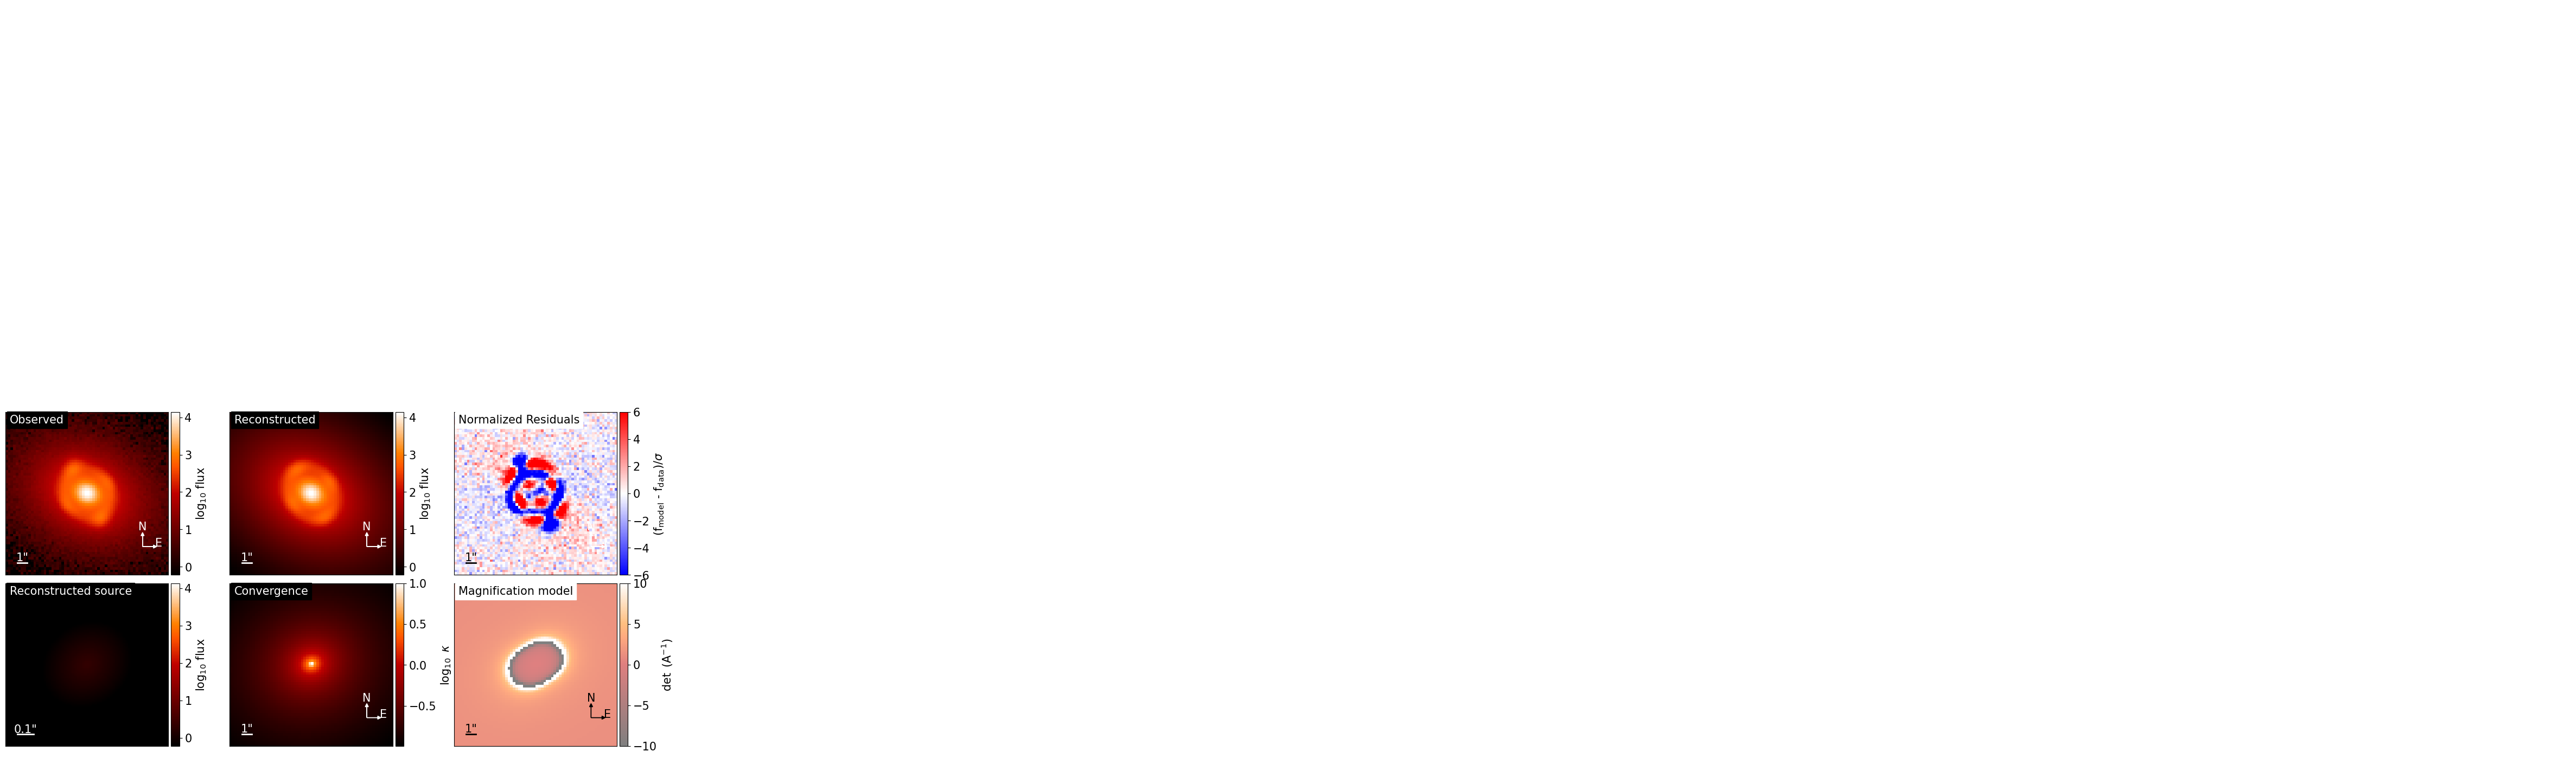

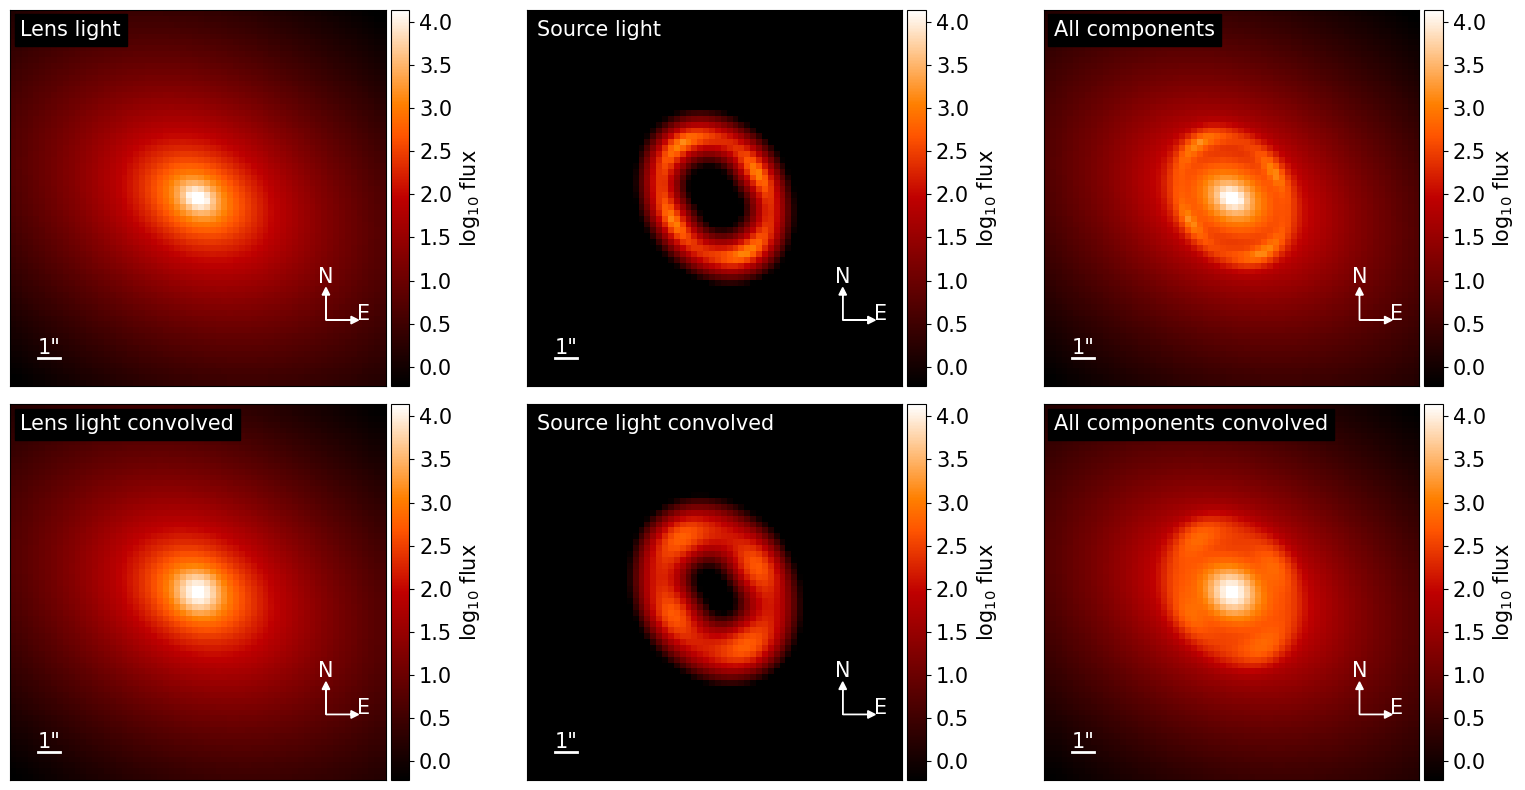

{'kwargs_lens': [{'theta_E': np.float64(2.467243653739937), 'gamma': np.float64(1.9960013351915484), 'e1': np.float64(0.04736445076983328), 'e2': np.float64(0.038137661000847575), 'center_x': np.float64(0.04042043728499879), 'center_y': np.float64(0.06154991823396986)}, {'gamma1': np.float64(-0.042934760495139834), 'gamma2': np.float64(-0.1056332199541046), 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': np.float64(5289.283794513939), 'R_sersic': np.float64(0.2956361996650248), 'n_sersic': np.float64(0.8951549013668204), 'e1': np.float64(0.020222151682390888), 'e2': np.float64(0.07162271028582096), 'center_x': np.float64(0.025535029744222813), 'center_y': np.float64(0.043302984330821075)}], 'kwargs_lens_light': [{'amp': np.float64(60470.48401158755), 'R_sersic': np.float64(0.6223040886541227), 'n_sersic': np.float64(3.89508701369687), 'e1': np.float64(0.08415869272139323), 'e2': np.float64(-0.11859227304434458), 'center_x': np.float64(-0.00046339604160416177), 'center_y': np.float64

/grad/a.saricaoglu/.conda/envs/rubinsforge/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


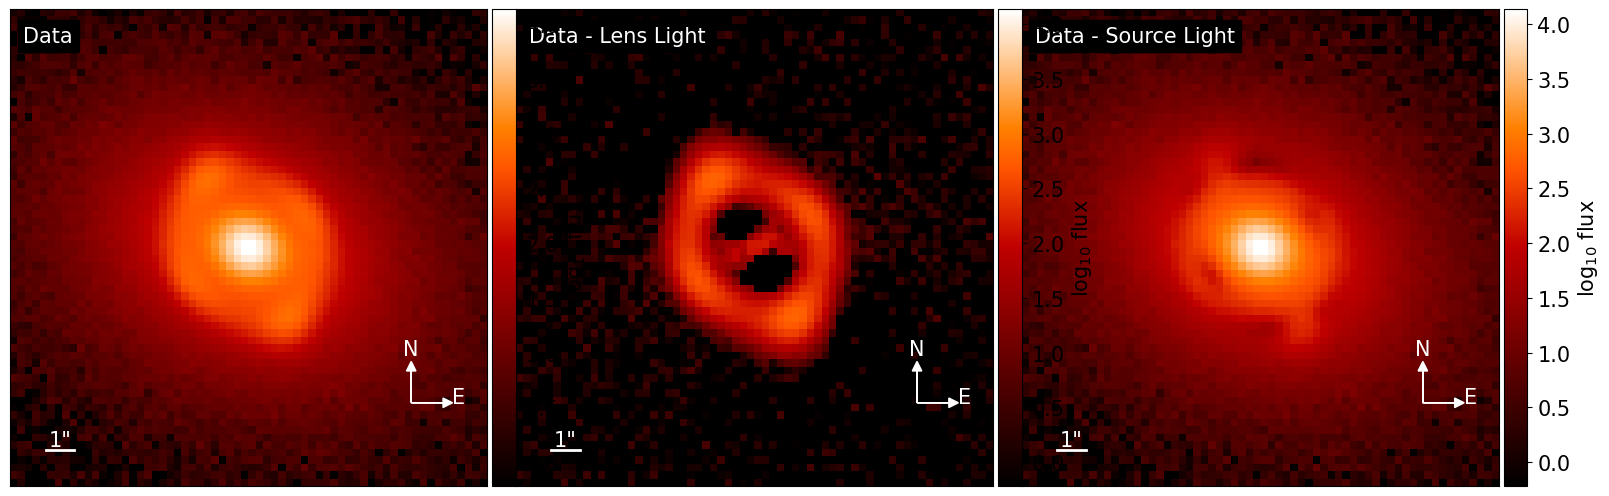

In [192]:
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


## Adding a clump
Now in a second step we add a clump in the lens model. This model is identical (in terms of parameterisation) as the created mock data. The aim now is that the PSO will find the clump at the right position with the right properties. This is a non-trivial convergence problem due to the many covariances also with the macro-model.

In [193]:
# add substructure

lens_model_substructure_list = ['EPL', 'SHEAR', 'CNFW']

# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append({'alpha_Rs': 0.01, 'r_core' : 0.01, 'Rs': 0.05, 'center_x': 0, 'center_y': 0})
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.01, 'r_core' : 0.01,'Rs': 0.05, 'center_x': 3, 'center_y': 3})
kwargs_lower_lens.append({'alpha_Rs': 0.,'r_core' : 0., 'Rs': 0.0001, 'center_x': -3, 'center_y': -3})
kwargs_upper_lens.append({'alpha_Rs': 1., 'r_core' : 1. ,'Rs': 2, 'center_x': 3, 'center_y': 3})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.01, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 800, 'n_iterations': 100}]]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')


Computing the PSO ...


100%|██████████| 100/100 [02:47<00:00,  1.68s/it]

Max iteration reached! Stopping.
-1.0335010495826458 reduced X^2 of best position
-2102.657885375893 log likelihood
4069 effective number of data points
[{'theta_E': np.float64(2.4939958846522026), 'gamma': np.float64(2.126235804822492), 'e1': np.float64(0.08435959634695199), 'e2': np.float64(0.09431969363879912), 'center_x': np.float64(0.051697804847726674), 'center_y': np.float64(0.016159456891949985)}, {'gamma1': np.float64(-0.0221565930394808), 'gamma2': np.float64(-0.07845116624185962), 'ra_0': 0, 'dec_0': 0}, {'Rs': np.float64(0.47299365369027185), 'alpha_Rs': np.float64(0.09414299137007943), 'r_core': np.float64(0.07603630714607888), 'center_x': np.float64(-1.2152265035673246), 'center_y': np.float64(-0.1607503142123249)}] lens result
[{'amp': 1, 'R_sersic': np.float64(0.3402877063688008), 'n_sersic': np.float64(1.0070408956832726), 'e1': np.float64(-0.2889926755578829), 'e2': np.float64(-0.1855262938260602), 'center_x': np.float64(0.002350642489591196), 'center_y': np.float64(-

/tmp/ipykernel_3790809/1127533767.py:11: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


-1.0266884205936977 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.0266884205936975


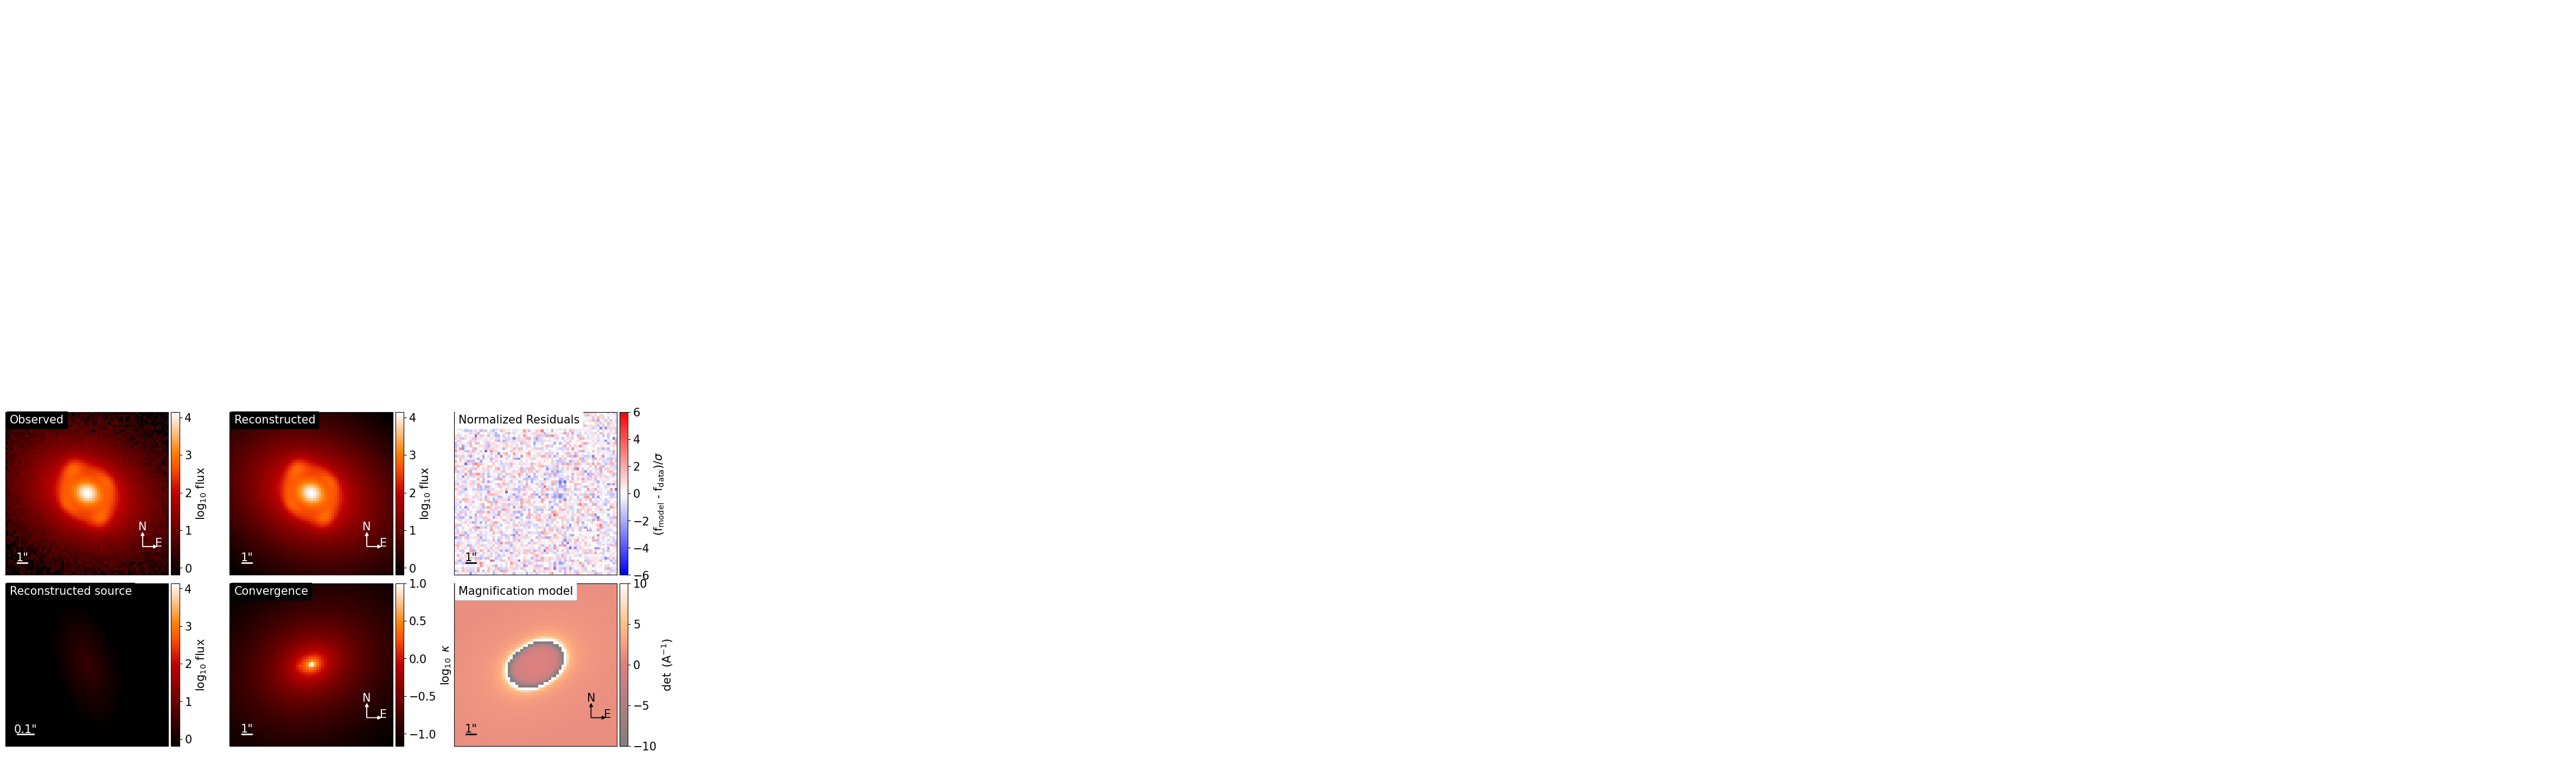

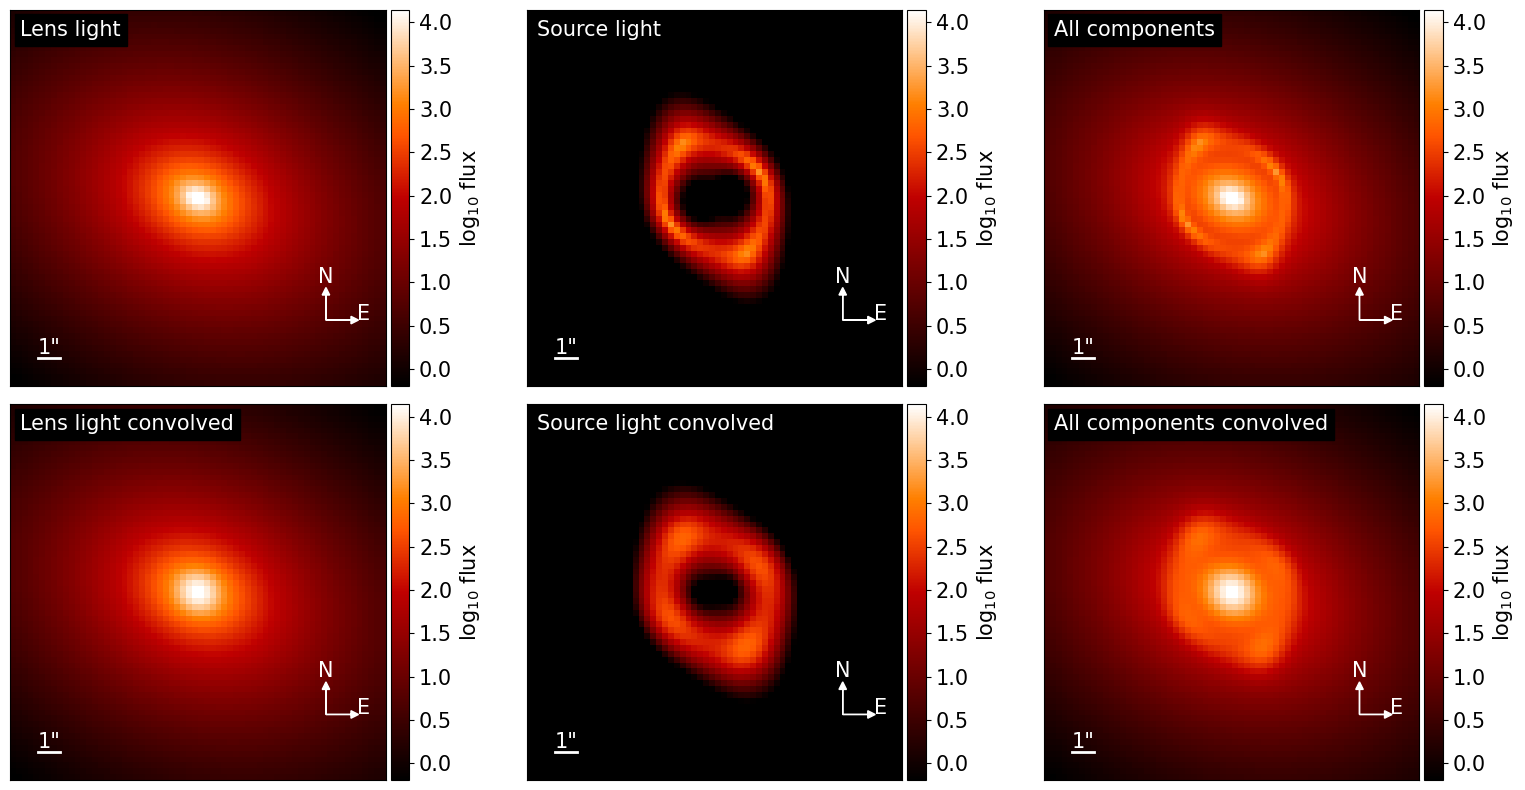

{'kwargs_lens': [{'theta_E': np.float64(2.4939958846522026), 'gamma': np.float64(2.126235804822492), 'e1': np.float64(0.08435959634695199), 'e2': np.float64(0.09431969363879912), 'center_x': np.float64(0.051697804847726674), 'center_y': np.float64(0.016159456891949985)}, {'gamma1': np.float64(-0.0221565930394808), 'gamma2': np.float64(-0.07845116624185962), 'ra_0': 0, 'dec_0': 0}, {'Rs': np.float64(0.47299365369027185), 'alpha_Rs': np.float64(0.09414299137007943), 'r_core': np.float64(0.07603630714607888), 'center_x': np.float64(-1.2152265035673246), 'center_y': np.float64(-0.1607503142123249)}], 'kwargs_source': [{'amp': np.float64(4972.945008238865), 'R_sersic': np.float64(0.3402877063688008), 'n_sersic': np.float64(1.0070408956832726), 'e1': np.float64(-0.2889926755578829), 'e2': np.float64(-0.1855262938260602), 'center_x': np.float64(0.002350642489591196), 'center_y': np.float64(-0.0013315772200232499)}], 'kwargs_lens_light': [{'amp': np.float64(63525.33954815413), 'R_sersic': np.f

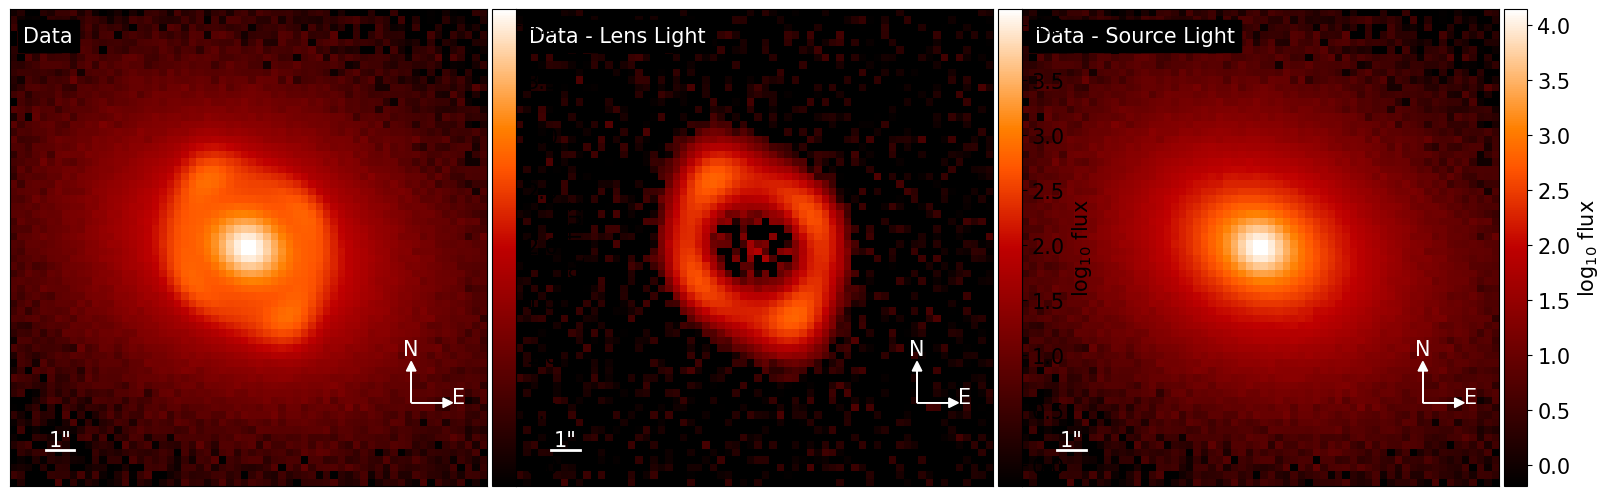

In [194]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)
    
f, axes = plt.subplots(1, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.subtract_from_data_plot(ax=axes[0], text='Data')
modelPlot.subtract_from_data_plot(ax=axes[1], text='Data - Lens Light', lens_light_add=True)
modelPlot.subtract_from_data_plot(ax=axes[2], text='Data - Source Light', source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

## MCMC of the parameter space
after convergence (please check) we run an MCMC sampler (emcee with CosmoHammer)

In [195]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append(kwargs_result['kwargs_lens'][0])
#kwargs_lens_init.append(kwargs_pemd)
kwargs_lens_sigma.append({'theta_E': .01, 'e1': 0.01, 'e2': 0.01, 'gamma': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01,'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][1])
#kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})


fixed_lens.append({})
kwargs_lens_init.append(kwargs_result['kwargs_lens'][2])
#kwargs_lens_init.append(kwargs_nfw)
kwargs_lens_sigma.append({'alpha_Rs': 0.05, 'r_core': 0.05 , 'Rs': 0.05, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'alpha_Rs': 0.,'r_core': 0.00 , 'Rs': 0.0001, 'center_x': -2, 'center_y': -2})
kwargs_upper_lens.append({'alpha_Rs': 1., 'r_core': 1. ,'Rs': 2, 'center_x': 2, 'center_y': 2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_result['kwargs_lens_light'][0])
kwargs_lens_light_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_result['kwargs_source'][0])
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.01, 'e2': 0.01, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_model = {'lens_model_list': lens_model_substructure_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                 }

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params,
                'lens_light_model': lens_light_params}


fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 6, 'sigma_scale': 0.1}]]
start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')



MCMC selected. Sampling with default option emcee.


100%|██████████| 400/400 [02:27<00:00,  2.71it/s]

Computing the MCMC...
Number of walkers =  150
Burn-in iterations:  200
Sampling iterations (in current run): 400
147.74787664413452 time taken for MCMC sampling
147.76558017730713 total time needed for computation
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


number of non-linear parameters in the MCMC process:  25
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'Rs_lens2', 'alpha_Rs_lens2', 'r_core_lens2', 'center_x_lens2', 'center_y_lens2', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  30000


/tmp/ipykernel_3790809/702161614.py:36: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


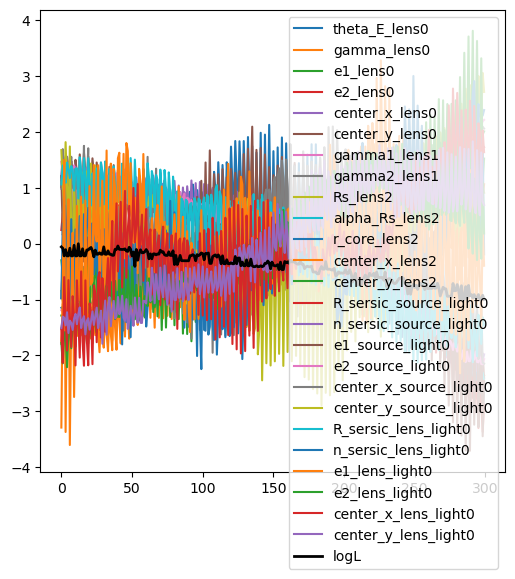

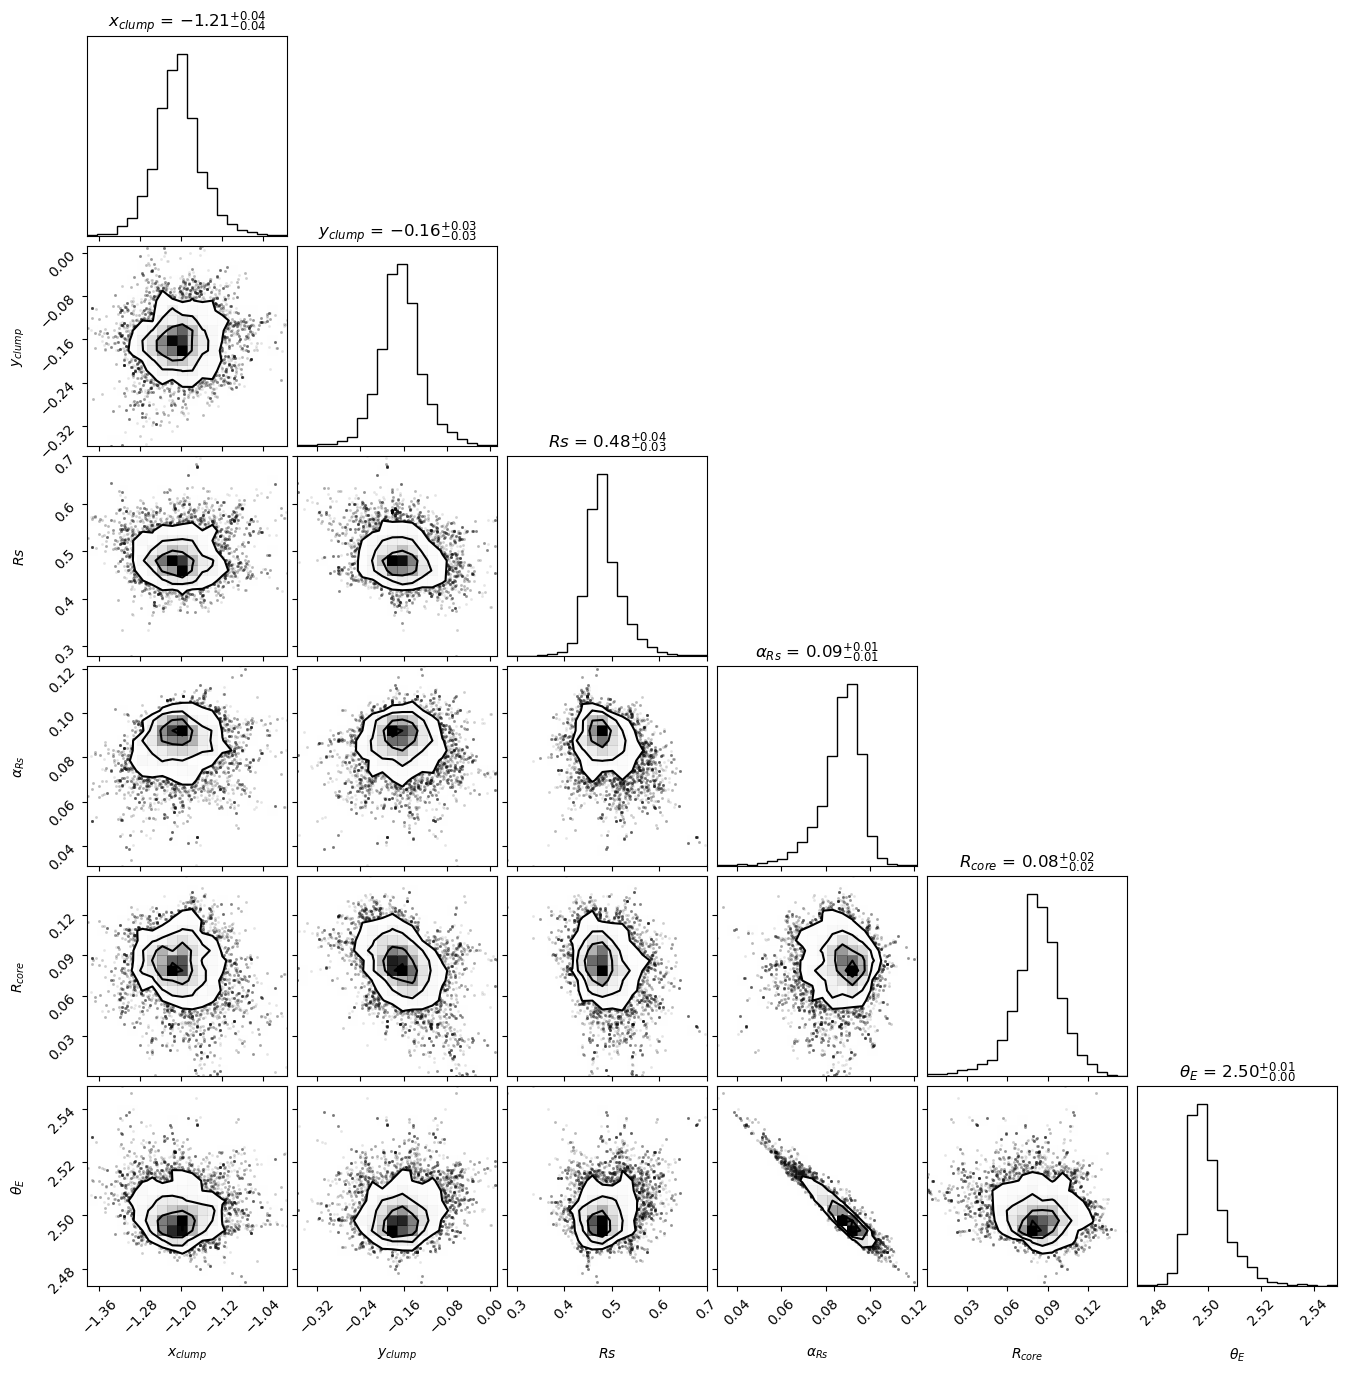

In [196]:
from lenstronomy.Plots import chain_plot

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, fixed_source, fixed_lens_light, kwargs_lens_init=kwargs_lens, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()


mcmc_new_list = []
labels_new = [r"$x_{clump}$", r"$y_{clump}$", r"$Rs$", r"$\alpha_{Rs}$", r"$R_{core}$", r"$\theta_E$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_result = param.args2kwargs(samples_mcmc[i])
    mcmc_new_list.append([kwargs_result['kwargs_lens'][2]['center_x'], 
                          kwargs_result['kwargs_lens'][2]['center_y'], 
                          kwargs_result['kwargs_lens'][2]['Rs'], 
                          kwargs_result['kwargs_lens'][2]['alpha_Rs'],
                          kwargs_result['kwargs_lens'][2]['r_core'],
                          kwargs_result['kwargs_lens'][0]['theta_E']])

fig = corner.corner(np.array(mcmc_new_list), labels=labels_new, show_titles=True)
fig.show()

## creating mock images from postit-stamps of other images
One specific light model option is 'INTERPOL' where you can pass a 2d grid of surface brightness values (e.g. a real image). The 'INTERPOL' class then interpolates this grid and enables the surface brightness evaluation also under possible distortions. The 'INTERPOL' class also allows to scale the input image and rotate it to the desired angle. In the SimulationAPI, you can furthermore assigne the object a magnitude and the integrated surface brightness will be scaled to match the assigned total magnitude.

In the following example we create an 'image' with the surface brightness of the pixels representing a simple Gaussian distribution and then use different scales and magnitudes of this 'image' to represent the lensing galaxy and the lensed host galaxy of a point source.

/grad/a.saricaoglu/.conda/envs/rubinsforge/lib/python3.13/site-packages/lenstronomy/LensModel/lens_model.py:96: UserWarning: Astropy Cosmology is provided. Make sure your cosmology model is consistent with the cosmology_model argument.
  warnings.warn(


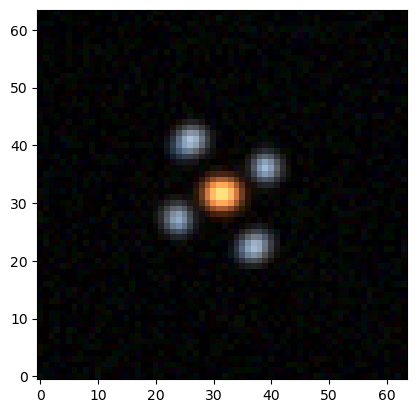

In [197]:
kwargs_model_postit = {'lens_model_list': lens_model_list,  # list of lens models to be used
                'lens_light_model_list': ['INTERPOL'],  # list of unlensed light models to be used
                'source_light_model_list': ['INTERPOL'],  # list of extended source models to be used
                'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
    }


sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_postit)
sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_postit)
sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_postit)

# return the ImSim instance. With this class instance, you can compute all the
# modelling accessible of the core modules. See class documentation and other notebooks.
imSim_g = sim_g.image_model_class(kwargs_numerics)
imSim_r = sim_r.image_model_class(kwargs_numerics)
imSim_i = sim_i.image_model_class(kwargs_numerics)

# we make an 'image' based on a 2d gaussian
x_grid, y_grid = util.make_grid(numPix=10, deltapix=1)
flux = gauss.function(x_grid, y_grid, amp=1, sigma=2, e1=0.4, e2=0, center_x=0, center_y=0)
image_gauss = util.array2image(flux)

# g-band

# lens light
kwargs_lens_light_mag_g = [{'magnitude': 17, 'image': image_gauss, 'scale': 0.1, 'phi_G': 0, 'center_x': 0., 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 22, 'image': image_gauss, 'scale': 0.03, 'phi_G': 0.4, 'center_x': 0., 'center_y': 0}]


# and now we define the colors of the other two bands

# r-band
g_r_source = 1  # color mag_g - mag_r for source
g_r_lens = -1  # color mag_g - mag_r for lens light
g_r_ps = 0
kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source

kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps


# i-band
g_i_source = 2
g_i_lens = -2
g_i_ps = 0
kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'] -= g_i_source

kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps

# turn magnitude kwargs into lenstronomy kwargs
kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_i.magnitude2amplitude(kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)

image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
image_r = imSim_r.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
image_i = imSim_i.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

# add noise
image_g += sim_g.noise_for_model(model=image_g)
image_r += sim_r.noise_for_model(model=image_r)
image_i += sim_i.noise_for_model(model=image_i)

# and plot it

img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)
img[:,:,0] = plot_util.sqrt(image_g, scale_min=0, scale_max=1000)
img[:,:,1] = plot_util.sqrt(image_r, scale_min=0, scale_max=1000)
img[:,:,2] = plot_util.sqrt(image_i, scale_min=0, scale_max=1000)

plt.clf()
plt.imshow(img, aspect='equal', origin='lower')
plt.show()

## time variable source modeling
The SimulationAPI also comes with a class $\texttt{PointSourceVariability}$ which enables to model a variable (lensed) point source. It builts upon the base class $\texttt{SimAPI}$ and allows to provide a time-variable function to be passed and the simulation be made at different time steps. This can e.g. be used to simulate lensed supernovae and provides an example of how potentially even more complex time variablility simulations may be performed with lenstronomy.

In [198]:
# we define a time variable function in magnitude space
def var_func(time):
    sigma = 5
    mag_0 = 19
    cps = np.exp(-time ** 2 / (2 * sigma ** 2))
    mag = data_util.cps2magnitude(cps, magnitude_zero_point=0)
    mag_norm = data_util.cps2magnitude(1, magnitude_zero_point=0)
    mag_return = mag - mag_norm + mag_0
    return mag_return

kwargs_model_time_var = {'lens_model_list': lens_model_list,  # list of lens models to be used
                'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
                         'z_lens': 0.5, 'z_source': 2
               }
# source position
source_x, source_y = 0.01, 0.05
# lens light
kwargs_lens_light_mag_g = [{'magnitude': 19, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1, 'e1': -0.3, 'e2': -0.2, 'center_x': 0, 'center_y': 0}]



from lenstronomy.SimulationAPI.point_source_variability import PointSourceVariability
ps_var = PointSourceVariability(source_x, source_y, var_func, numpix, kwargs_g_band, kwargs_model_time_var, kwargs_numerics,
                 kwargs_lens, kwargs_source_mag_g, kwargs_lens_light_mag_g, kwargs_ps_mag=None)

# these are the time delays of the multiple images (relative to the first appearing)
print(ps_var.delays)

[ 0.         17.29120971 83.13297674 91.60868217]


/tmp/ipykernel_3790809/1457202442.py:4: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(image_g), origin='lower')


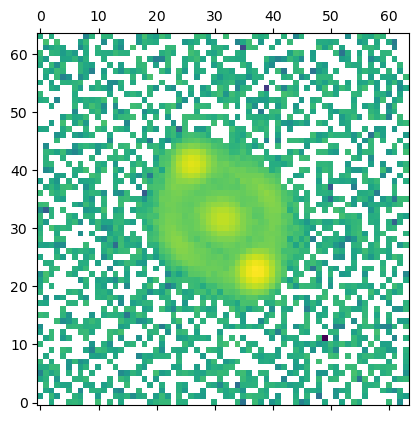

In [199]:
time = 10  # chose a time stamp of the image
image_g = ps_var.image_time(time=time)
image_g += sim_g.noise_for_model(model=image_g)
plt.matshow(np.log10(image_g), origin='lower')
plt.show()



## multi lens and multi source plane modeling (compound lenses)
Lenstronomy has full multi-plane ray-tracing capabilities and its design allows to place different sources (surface brightness models) at different redshifts (source planes). This functionality is also enable within the SimulationAPI module.

Multiple lens or source planes require the knowledge of the relative optical distances, or given their redshifts a specific cosmological model. The light models are defined relative to the angle to the specific redshift assuming a homogeneous line of sight (angular diameter distances of the background cosmology). The lensing deflection angles are defined in reduced deflections in respect of the lensing redshift to a specified source redshift.


In [200]:
# we define a specific cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

kwargs_model_composite = {'lens_model_list': lens_model_list,  # list of lens models to be used
                          'lens_redshift_list': [0.5, 0.5, 0.5],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [0.8, 2.5],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source_convention': 3,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                          'z_source': 3,  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources
    }

# we only simulate here the g-band, see above how to combine multiple bands
sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_composite)
imSim_g = sim_g.image_model_class(kwargs_numerics)

# # lens light
# kwargs_lens_light_mag_g = [{'magnitude': 20, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# # source light
# kwargs_source_mag_g = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1, 'e1': -0.3, 'e2': -0.2, 'center_x': 0, 'center_y': 0},
#                       {'magnitude': 23, 'R_sersic': 0.8, 'n_sersic': 2, 'center_x': 0.2, 'center_y': 0}]
kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)


image_g = imSim_g.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
image_g += sim_g.noise_for_model(model=image_g)

plt.matshow(np.log10(image_g))
plt.show()

/grad/a.saricaoglu/.conda/envs/rubinsforge/lib/python3.13/site-packages/lenstronomy/LensModel/MultiPlane/multi_plane.py:76: UserWarning: Cosmology is provided. Make sure your cosmological model is consistent with the cosmology_model argument.
  warnings.warn(


IndexError: list index out of range

## Using physical deflector units
The default setting for the lens model parameters are reduced deflector units. The $\texttt{SimulationAPI}$ module provides a convenient function to use physical mass unit parameterizations and to wrapp them into the standard reduced deflection angle convention of $\texttt{lenstronomy}$.

For lens models parameterized with Einstein radius $\theta_E$, the velocity dispersion 'sigma_v' can be set instead (in units km/s) and given a redshift of lens and source and a specified cosmology, the Einstein radius is computed. For NFW profiles, 'M200' and 'concentration' can be set instead of 'alpha_Rs' and 'Rs' and those will be converted into the referenced lensing quantities.

In [51]:
kwargs_model_physical = {'lens_model_list': ['SIE', 'CNFW'],  # list of lens models to be used
                          'lens_redshift_list': [0.5, 0.3],  # list of redshift of the deflections
                          'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE', 'SERSIC'],  # list of extended source models to be used
                          'source_redshift_list': [0.8, 2.5],  # list of redshfits of the sources in same order as source_light_model_list
                          'cosmo': cosmo,  # astropy.cosmology instance
                          'z_source_convention': 3,  # source redshfit to which the reduced deflections are computed, is the maximal redshift of the ray-tracing
                          'z_source': 3,  # redshift of the default source (if not further specified by 'source_redshift_list') and also serves as the redshift of lensed point sources
    }

kwargs_mass = [{'sigma_v': 250, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0},
              {'M200': 10**13, 'concentration': 4, 'center_x': 1, 'center_y': 0}]

sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)

imSim = sim.image_model_class(kwargs_numerics)

kwargs_lens = sim.physical2lensing_conversion(kwargs_mass=kwargs_mass)
print(kwargs_lens)

# lens light
kwargs_lens_light_mag_g = [{'magnitude': 20, 'R_sersic': .6, 'n_sersic': 4, 'e1': 0.1, 'e2': -0.1, 'center_x': 0, 'center_y': 0}]
# source light
kwargs_source_mag_g = [{'magnitude': 22, 'R_sersic': 0.3, 'n_sersic': 1, 'e1': -0.3, 'e2': -0.2, 'center_x': 0, 'center_y': 0},
                      {'magnitude': 21, 'R_sersic': 0.8, 'n_sersic': 2, 'center_x': 0.2, 'center_y': 0}]
kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_g.magnitude2amplitude(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)


image_g = imSim.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g)
image_g += sim.noise_for_model(model=image_g)

plt.matshow(np.log10(image_g))
plt.show()


[{'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': 0, 'theta_E': np.float64(1.2668727770873223)}, {'center_x': 1, 'center_y': 0, 'Rs': np.float64(22.518063346622725), 'alpha_Rs': np.float64(1.2121509235987251)}]


TypeError: CNFW.derivatives() missing 1 required positional argument: 'r_core'